This notebooks contains code for GRU and LSTM models for 5-class emotion classification.<br />
Run from scripts directory.

In [5]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import urllib.request
import zipfile

from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [6]:
num_classes = 5

# Number of dimensions for word embeddings.
embed_num_dims = 300

# Similar to CNN, use 500 as max sequence length.
max_seq_len = 500

In [7]:
# Define emotion classes
emotions = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [8]:
data_train = pd.read_csv('../data/training_data/data_train_5_classes.csv')
data_test = pd.read_csv('../data/training_data/data_test_5_classes.csv')

In [32]:
# Split training data into training and validation sets
X_train, X_dev, y_train, y_dev = train_test_split(data_train.Text, data_train.Emotion,
                                                  shuffle=True,
                                                  stratify=data_train.Emotion, 
                                                  test_size=0.15)
X_test = data_test.Text
y_test = data_test.Emotion

In [33]:
def clean_text(text):
    """Clean text and tokenise.""" 
    text = text.lower()
    
    # Remove common contractions.
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"\'s",' ', text)
    text = re.sub(r"\'ve", ' have ', text)
    text = re.sub(r"n't", ' not ', text)
    text = re.sub(r"im", 'i am ', text)
    text = re.sub(r"i'm", 'i am ', text)
    text = re.sub(r"\'re", ' are ', text)
    text = re.sub(r"\'ll", ' will ', text)
    
    # Remove hashtags and tags.
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)    
                
    # Remove operations and process puctuation.           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
  
    # Remove missed symbols.
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    text = word_tokenize(text)
    return ' '.join(text)

In [34]:
data = data_train.append(data_test, ignore_index=True)
texts = [clean_text(text) for text in data.Text]

texts_train = [clean_text(text) for text in X_train]
texts_dev = [clean_text(text) for text in X_dev]
texts_test = [clean_text(text) for text in X_test]

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

seq_train = tokenizer.texts_to_sequences(texts_train)
seq_dev = tokenizer.texts_to_sequences(texts_dev)
seq_test = tokenizer.texts_to_sequences(texts_test)

In [36]:
index_of_words = tokenizer.word_index

# Reserve 1 for padding.
vocab_size = len(index_of_words) + 1

In [37]:
X_train_pad = pad_sequences(seq_train, maxlen = max_seq_len)
X_dev_pad = pad_sequences(seq_dev, maxlen = max_seq_len)
X_test_pad = pad_sequences(seq_test, maxlen = max_seq_len)

In [38]:
# Assign integer labels to y values.
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

y_train = [encoding[x] for x in y_train]
y_dev = [encoding[x] for x in y_dev]
y_test = [encoding[x] for x in y_test]

y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [39]:
def create_embedding_matrix(filepath, word_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [40]:
fname = 'embeddings/wiki-news-300d-1M.vec'
if not os.path.isfile(fname):
    print('Geting word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('Done.')
    os.remove('wiki-news-300d-1M.vec.zip')

In [41]:
embedding_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims, vocab_size)

In [16]:
# Hyperparameters to try with the model (code omitted).
# A model was created for each combination using the sequence below and performance compared.
activations = ['softmax', 'tanh', 'relu']
dropouts = [0.1, 0.2, 0.3, 0.4]
rec_dropouts = [0.1, 0.2, 0.3, 0.4]
batches = [32, 64, 128]

According to recent research (e.g., https://arxiv.org/pdf/1702.01923.pdf or http://www.krishisanskriti.org/vol_image/21Jul201503071043%20%20%20%20%20Faiyz%20Ahmad%202%20%20%20%20%20%20%20%20%2059-63.pdf) GRU is more efficient for sentiment analysis. With this in mind, assume it is also more efficient for emotion classification (during hyperparameter search it performed marginally better).

In [42]:
# Define model architecture.
use_gru = True # False to use LSTM.
dropout = 0.1
rec_dropout = 0.1
batch_size = 64

gru_output_size = 128
max_epochs = 30

embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedding_matrix],
                         trainable=False)
model = Sequential()
model.add(embedd_layer)
if use_gru:
    model.add(Bidirectional(GRU(units=gru_output_size,
                          dropout=dropout,
                          recurrent_dropout=rec_dropout)))
else:
    model.add(Bidirectional(LSTM(units=gru_output_size,
                          dropout=dropout,
                          recurrent_dropout=rec_dropout)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3603300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 3,934,825
Trainable params: 331,525
Non-trainable params: 3,603,300
_________________________________________________________________


In [43]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


history = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=max_epochs,
                 validation_data=(X_dev_pad, y_dev),
                 callbacks=[early_stopping_monitor])

Epoch 1/30
106/106 [==============================] - 232s 2s/step - loss: 1.4716 - accuracy: 0.3498 - val_loss: 1.1649 - val_accuracy: 0.5458
Epoch 2/30
106/106 [==============================] - 260s 2s/step - loss: 1.0481 - accuracy: 0.5960 - val_loss: 0.8274 - val_accuracy: 0.6935
Epoch 3/30
106/106 [==============================] - 244s 2s/step - loss: 0.7992 - accuracy: 0.7122 - val_loss: 0.7572 - val_accuracy: 0.7162
Epoch 4/30
106/106 [==============================] - 288s 3s/step - loss: 0.7248 - accuracy: 0.7352 - val_loss: 0.7332 - val_accuracy: 0.7448
Epoch 5/30
106/106 [==============================] - 271s 3s/step - loss: 0.6740 - accuracy: 0.7628 - val_loss: 0.7404 - val_accuracy: 0.7305
Epoch 6/30
106/106 [==============================] - 248s 2s/step - loss: 0.6253 - accuracy: 0.7751 - val_loss: 0.7149 - val_accuracy: 0.7347
Epoch 7/30
106/106 [==============================] - 263s 2s/step - loss: 0.5971 - accuracy: 0.7884 - val_loss: 0.7299 - val_accuracy: 0.7313

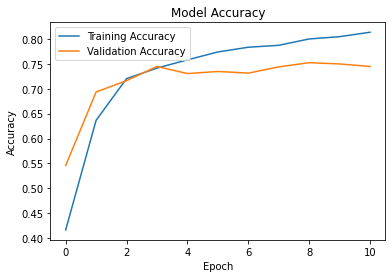

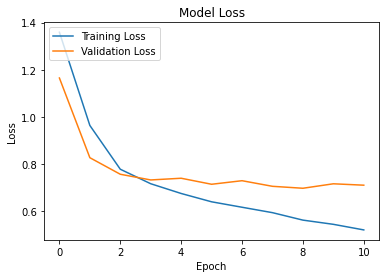

In [44]:
# Plot loss and accuracy.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [45]:
# See test set results.
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [emotions[pred] for pred in predictions]

In [46]:
print('GRU 5 classes classification report: ') 
print(classification_report(data_test.Emotion, predictions, digits=4))

GRU 5 classes classification report: 
              precision    recall  f1-score   support

       anger     0.7458    0.6349    0.6859       693
        fear     0.7500    0.7599    0.7549       679
         joy     0.7139    0.7694    0.7406       707
     neutral     0.7320    0.7962    0.7628       638
     sadness     0.7102    0.6923    0.7011       676

    accuracy                         0.7297      3393
   macro avg     0.7304    0.7306    0.7291      3393
weighted avg     0.7303    0.7297    0.7286      3393



Text(0.5, 1.0, 'GRU 5 classes confusion matrix')

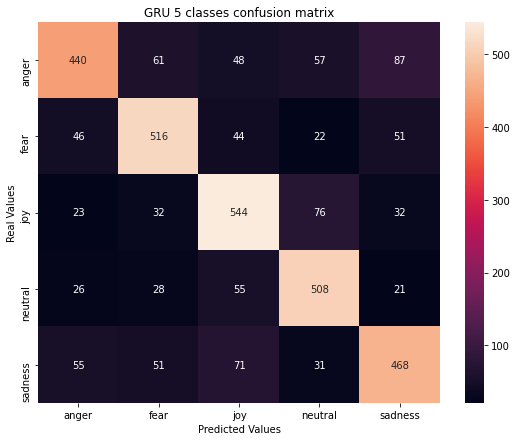

In [47]:
# Get confusion matrix.
df_cm = pd.DataFrame(confusion_matrix(data_test.Emotion, predictions), index = [i for i in ['anger', 'fear', 'joy', 'neutral', 'sadness']],
                  columns = [i for i in ['anger', 'fear', 'joy', 'neutral', 'sadness']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('GRU 5 classes confusion matrix')

In [55]:
model.save('trained_models/gru_w2v_final.h5')

In [48]:
amazon = pd.read_csv('../data/preprocessed/amazon.csv')

In [49]:
amazon_text = amazon.REVIEW_TEXT
amazon_texts = [clean_text(text) for text in amazon_text]
seq_amazon = tokenizer.texts_to_sequences(amazon_texts)
amazon_text_pad = pad_sequences(seq_amazon, maxlen = max_seq_len)

In [50]:
for emotion in emotions:
    amazon[emotion] = 0
amazon['PREDICTION'] = 0

In [51]:
predictions_amazon = model.predict(amazon_text_pad)

In [52]:
for i in range(len(amazon['REVIEW_TEXT'])):
    if i%1000 == 0:
        print('processing', i, ' of', len(amazon))
    for j, emotion in enumerate(emotions):
        amazon.iloc[i, amazon.columns.get_loc(emotion)] = predictions_amazon[i][j]
    prediction = np.argmax(predictions_amazon[i])
    prediction = emotions[prediction]
    amazon.iloc[i, amazon.columns.get_loc('PREDICTION')] = prediction

processing 0  of 20974
processing 1000  of 20974
processing 2000  of 20974
processing 3000  of 20974
processing 4000  of 20974
processing 5000  of 20974
processing 6000  of 20974
processing 7000  of 20974
processing 8000  of 20974
processing 9000  of 20974
processing 10000  of 20974
processing 11000  of 20974
processing 12000  of 20974
processing 13000  of 20974
processing 14000  of 20974
processing 15000  of 20974
processing 16000  of 20974
processing 17000  of 20974
processing 18000  of 20974
processing 19000  of 20974
processing 20000  of 20974


In [30]:
amazon

,REVIEW_TEXT,VERACITY,joy,fear,anger,sadness,neutral,PREDICTION
0,"When least you think so, this product will sav...",Fake,0.131806,0.071092,0.181366,0.043201,0.572534,neutral
1,Lithium batteries are something new introduced...,Fake,0.131323,0.134439,0.476185,0.062931,0.195122,anger
2,I purchased this swing for my baby. She is 6 m...,Fake,0.276750,0.060132,0.387430,0.105716,0.169973,anger
3,I was looking for an inexpensive desk calcolat...,Fake,0.154393,0.264982,0.289989,0.092828,0.197809,anger
4,I only use it twice a week and the results are...,Fake,0.119297,0.406612,0.303040,0.066733,0.104318,fear
...,...,...,...,...,...,...,...,...
20969,"I bought these for work. I have high arches, ...",Real,0.159864,0.189525,0.255711,0.079602,0.315298,neutral
20970,Crocs are one of only two brands of shoes that...,Real,0.465956,0.224929,0.070325,0.084678,0.154112,joy
20971,I love moccasins This fit like it was custom ...,Real,0.294881,0.092803,0.299273,0.193898,0.119146,anger
20972,I wish these were a little more durable. I got...,Real,0.483040,0.108364,0.126710,0.069493,0.212393,joy


<AxesSubplot:title={'center':'GRU 5 classes predictions'}>

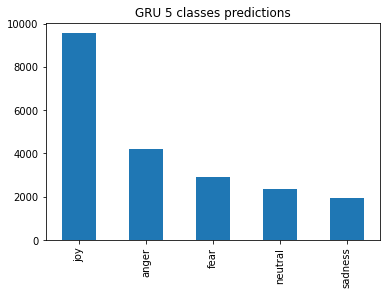

In [53]:
amazon.PREDICTION.value_counts().plot(kind='bar', title='GRU 5 classes predictions')

In [39]:
amazon.to_csv('../data/results/amazon_gru5.csv', index=False)